# Practice 5 - Parameter Efficient Tunning (ALBERT, DistillBERT) & Prompt Tuning

### Dataset Load & Preprocessing

In [1]:
with open('/kaggle/input/2024-1-nlp-5/Korean_movie_reviews_2016.txt/Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

words_list = [doc.strip().split() for doc in texts]
print(words_list[:2])
print(labels[:2])
print(len(texts))
print(len(labels))

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]
(0, 1)
165384
165384


In [2]:
type(texts), type(labels)

(tuple, tuple)

In [3]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

2024-06-23 05:55:01.233083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 05:55:01.233198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 05:55:01.362069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_remain, y_train, y_remain = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=0)

In [5]:
len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test)

(132307, 132307, 16538, 16538, 16539, 16539)

In [6]:
X_train[0]

'정말 이런 영화 보는 시간 넘아 깝 고통스러웠 영화 보고 아팠'

In [7]:
y_train[0]

array([1., 0.])

In [ ]:
# X_train : string으로 이루어진 list
# y_train : numpy.ndarray

## 실습 5.1 - Parameter Efficient Tuning with ALBERT

### Load Tokenizer & Dataset Split

In [31]:
from transformers import BertTokenizer, TFAlbertForSequenceClassification, AlbertForSequenceClassification
tokenizer= BertTokenizer.from_pretrained("kykim/albert-kor-base")

tokenizer_config.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [32]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_val_tokenized = tokenizer(X_val, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [10]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [11]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
type(X_train_tokenized)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
len(X_train_tokenized.items())

In [13]:
X_train_tokenized['input_ids'][0]

array([    2, 14038, 14119, 14632, 15024, 14084,  2866,  8095,  2506,
       20279, 14233,  8258, 14632, 14221, 28733,     3,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [14]:
X_train_tokenized['input_ids'].shape

(132307, 30)

In [15]:
X_train_tokenized['token_type_ids'][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
X_train_tokenized['attention_mask'][0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
len(X_train_tokenized['input_ids'])

132307

In [18]:
type(X_train_tokenized['input_ids']), type(y_train)

(numpy.ndarray, numpy.ndarray)

### Load Model

In [33]:
#Tensorflow based!!
#albert_model = TFAlbertForSequenceClassification.from_pretrained("kykim/albert-kor-base", num_labels=2, from_pt=True)
albert_model = AlbertForSequenceClassification.from_pretrained("kykim/albert-kor-base", num_labels=2)
#albert_model.summary()


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at kykim/albert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 실습 및 과제 5.1

Finetune your ALBERT model with "Korean_movie_reviews_2016.txt" 데이터셋

In [ ]:
#X_train_tokenized.set_format("torch", columns=["input_ids","attention_mask"])

In [ ]:
y_train[0]

In [6]:
import tensorflow as tf
import pandas as pd

def make_dataset(tokenizer_output, y):
    dataset_df = []
    for idx, sample in enumerate(tokenizer_output['input_ids']):
        row = [sample,tokenizer_output['token_type_ids'][idx],tokenizer_output['attention_mask'][idx],y[idx]]
        dataset_df.append(row)
    dataset_df = pd.DataFrame(dataset_df, 
                                columns=['input_ids','token_type_ids','attention_mask','label'])
    return dataset_df

In [35]:
train_dataset_df = make_dataset(X_train_tokenized, y_train)
val_dataset_df = make_dataset(X_val_tokenized, y_val)
test_dataset_df = make_dataset(X_test_tokenized, y_test)

In [ ]:
val_dataset_df

In [7]:
import datasets
from datasets import Dataset, DatasetDict
#print('to_tf_dataset' in dir(Dataset))

In [36]:
train_dataset = Dataset.from_pandas(train_dataset_df)
val_dataset = Dataset.from_pandas(val_dataset_df)
test_dataset = Dataset.from_pandas(test_dataset_df)

In [37]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
     num_rows: 132307
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
     num_rows: 16538
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
     num_rows: 16539
 }))

In [ ]:
import tensorflow as tf
import pandas as pd

train_dataset = train_dataset.to_tf_dataset(
    columns=['input_ids','token_type_ids','attention_mask'],
    label_cols=["label"],
    batch_size=64
)

#train_dataset = train_dataset.batch(64)
#test_dataset = test_dataset.batch(64)

In [ ]:
train_dataset

In [ ]:
#from tensorflow.keras.optimizers import Adam
optimizer = tf.optimizers.Adam(learning_rate=5e-5)
albert_model.compile(
    optimizer = optimizer,
    loss = albert_model.compute_loss,
    metrics = ['accuracy']
)

In [ ]:
pip install pandas --upgrade

In [ ]:
pip install numpy --upgrade

In [ ]:
history = albert_model.fit(train_dataset,epochs=3)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


def compute_metrics(val_result):
    #metric = load_metric("accuracy")
    
    labels = np.argmax(val_result.label_ids,axis=1)
    preds = np.argmax(val_result.predictions,axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc}

In [38]:
from transformers import Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="albert_model",
                                  num_train_epochs=2,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size= 32,
                                  weight_decay = 0.01,
                                 evaluation_strategy="epoch")

trainer_albert = Trainer(
    model=albert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)
#compute_metrics=compute_metrics,

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
trainer_albert.train()

Epoch,Training Loss,Validation Loss
1,0.232800,0.215145
2,0.171000,0.208819


TrainOutput(global_step=8270, training_loss=0.2198015930286486, metrics={'train_runtime': 995.8272, 'train_samples_per_second': 265.723, 'train_steps_per_second': 8.305, 'total_flos': 370533533151600.0, 'train_loss': 0.2198015930286486, 'epoch': 2.0})

In [ ]:
val_dataset

In [ ]:
np.array(val_dataset['input_ids'][0]).size

In [ ]:
type(val_dataset[0])

In [ ]:
val_dataset.column_names

In [ ]:
torch.Tensor(val_dataset[0]['input_ids']).unsqueeze(0)

In [ ]:
np.array(val_dataset[0]['input_ids']).size

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
def drop_label(sample):
    without_label = {k:torch.LongTensor(sample[k]).unsqueeze(0).to(device) for k in sample if k != 'label'}
    return without_label

In [ ]:
drop_label(val_dataset[0])['input_ids'].size()

In [ ]:
#import torch.LongTensor
output = albert_model(**(drop_label(val_dataset[200])))

In [ ]:
torch.argmax(torch.Tensor(val_dataset[200]['label']))

In [ ]:
torch.argmax(output.logits, axis=-1)

In [ ]:
val_result = trainer_albert.predict(val_dataset)

In [ ]:
answers = np.argmax(val_result.label_ids,axis=1)

In [ ]:
y_preds = np.argmax(val_result.predictions,axis=1)

In [ ]:
accuracy_score(answers,y_preds)

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues",ax=ax,colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

## Evaluation

In [ ]:
#model.evaluate(dict(X_test_tokenized), np.array(y_test))

In [ ]:
#y_preds = model.predict(dict(X_test_tokenized))
#prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
#y_predictions = np.argmax(prediction_probs, axis=1)
#y_test = np.argmax(y_test, axis=1)
#from sklearn.metrics import classification_report
#print(classification_report(y_predictions, y_test))

In [ ]:
val_result = trainer_albert.predict(val_dataset)
answers = np.argmax(val_result.label_ids,axis=1)
y_preds = np.argmax(val_result.predictions,axis=1)
accuracy_score(answers,y_preds)

In [ ]:
plot_confusion_matrix(answers,y_preds,['negative','positive'])

In [ ]:
test_result = trainer_albert.predict(test_dataset)
answers = np.argmax(test_result.label_ids,axis=1)
y_preds = np.argmax(test_result.predictions,axis=1)
accuracy_score(answers,y_preds)

In [ ]:
plot_confusion_matrix(answers,y_preds,['negative','positive'])

## 실습 5.2 - Parameter Efficient Tuning with DistillBERT

In [8]:
from transformers import BertTokenizer, DistilBertTokenizer, TFDistilBertForSequenceClassification

tokenizer= BertTokenizer.from_pretrained("monologg/distilkobert") #바꿔야함 distilkobert monologg/distilkobert
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_val_tokenized = tokenizer(X_val, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [9]:
train_dataset_df = make_dataset(X_train_tokenized, y_train)
val_dataset_df = make_dataset(X_val_tokenized, y_val)
test_dataset_df = make_dataset(X_test_tokenized, y_test)

In [10]:
import datasets
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_dataset_df)
val_dataset = Dataset.from_pandas(val_dataset_df)
test_dataset = Dataset.from_pandas(test_dataset_df)

In [11]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
     num_rows: 132307
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
     num_rows: 16538
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
     num_rows: 16539
 }))

### Load Model & Training

In [12]:
from transformers import DistilBertForSequenceClassification
model_distilBERT = DistilBertForSequenceClassification.from_pretrained("monologg/distilkobert", num_labels=2)
#model_distillBERT.summary()

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at monologg/distilkobert and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 실습 및 과제 5.2 

Finetune your DistilKoBERT model with "Korean_movie_reviews_2016.txt" 데이터셋

In [13]:
from transformers import Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="distilbert_model",
                                  num_train_epochs=2,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size= 32,
                                  weight_decay = 0.01,
                                 evaluation_strategy="epoch")

trainer_distilbert = Trainer(
    model=model_distilBERT,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer_distilbert.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.499500,0.479298
2,0.480500,0.471628


TrainOutput(global_step=8270, training_loss=0.49993628855916294, metrics={'train_runtime': 340.8191, 'train_samples_per_second': 776.406, 'train_steps_per_second': 24.265, 'total_flos': 1041073707446640.0, 'train_loss': 0.49993628855916294, 'epoch': 2.0})

## Evaluation

In [17]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

val_result = trainer_distilbert.predict(val_dataset)
answers = np.argmax(val_result.label_ids,axis=1)
y_preds = np.argmax(val_result.predictions,axis=1)
accuracy_score(answers,y_preds)

0.7642399322771798

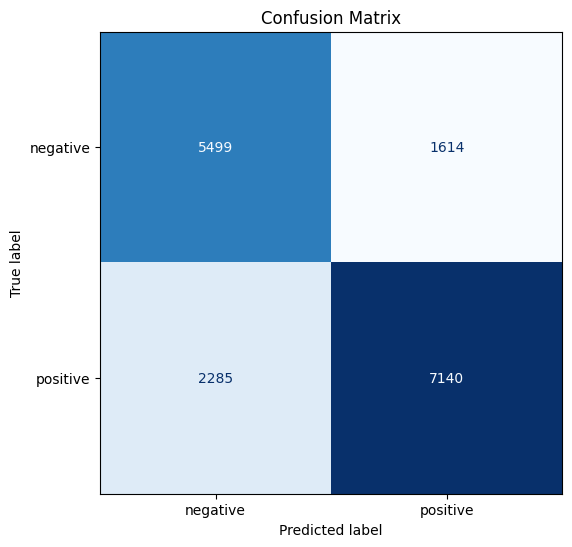

In [18]:
plot_confusion_matrix(answers,y_preds,['negative','positive'])

In [19]:
val_result = trainer_distilbert.predict(test_dataset)
answers = np.argmax(val_result.label_ids,axis=1)
y_preds = np.argmax(val_result.predictions,axis=1)
accuracy_score(answers,y_preds)

0.7594171352560615

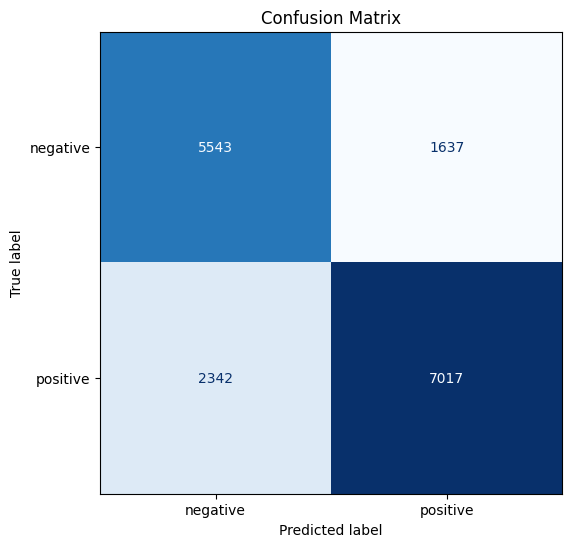

In [20]:
plot_confusion_matrix(answers,y_preds,['negative','positive'])

In [ ]:
#model.evaluate(dict(X_test_tokenized), np.array(y_test))

In [ ]:
y_preds = model.predict(dict(X_test_tokenized))
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
y_predictions = np.argmax(prediction_probs, axis=1)
y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

## 실습 5.3

- BERT 모델, ALBERT 모델, DistillBERT 모델의 크기와 성능을 비교하시오.

In [21]:
model_distilBERT.save_pretrained('distilbert_model')

In [40]:
albert_model.save_pretrained('albert_model')

In [24]:
sum(p.numel() for p in model_distilBERT.parameters())

28396034

In [25]:
from transformers import AlbertForSequenceClassification
model_albert = AlbertForSequenceClassification.from_pretrained("kykim/albert-kor-base", num_labels=2)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/53.3M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at kykim/albert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
from transformers import BertForSequenceClassification
model_vanila_bert = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [30]:
num_params_distilBERT = count_parameters(model_distilBERT)
num_params_albert = count_parameters(model_albert)
num_params_bert = count_parameters(model_vanila_bert)
print("ALBERT model parameters: ", num_params_albert)
print("DistilBERT model parameters: ", num_params_distilBERT)
print("BERT model parameters: ", num_params_bert)

ALBERT model parameters:  13188354
DistilBERT model parameters:  28396034
BERT model parameters:  177854978


In [8]:
from transformers import BertTokenizer

tokenizer= BertTokenizer.from_pretrained("kykim/bert-kor-base")
X_train_tokenized_test = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_val_tokenized_test = tokenizer(X_val, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized_test = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

train_dataset_df_test = make_dataset(X_train_tokenized_test, y_train)
val_dataset_df_test = make_dataset(X_val_tokenized_test, y_val)
test_dataset_df_test = make_dataset(X_test_tokenized_test, y_test)

train_dataset_test = Dataset.from_pandas(train_dataset_df_test)
val_dataset_test = Dataset.from_pandas(val_dataset_df_test)
test_dataset_test = Dataset.from_pandas(test_dataset_df_test)

tokenizer_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

In [10]:
train_dataset_test

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 132307
})

In [12]:
from transformers import BertForSequenceClassification
model_vanila_bert = BertForSequenceClassification.from_pretrained("kykim/bert-kor-base", num_labels=2)

pytorch_model.bin:   0%|          | 0.00/476M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="bert_model",
                                  num_train_epochs=2,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size= 32,
                                  weight_decay = 0.01,
                                 evaluation_strategy="epoch")

trainer_bert = Trainer(
    model=model_vanila_bert,
    args=training_args,
    train_dataset=train_dataset_test,
    eval_dataset=val_dataset_test
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x78a0fadac5b0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 78a0a8761f00, raw_cell="from transformers import Trainer
from transformers.." store_history=True silent=False shell_futures=True cell_id=30c3d209-0a9f-49dc-8c2c-2ab0e4023cc4>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x78a0fadac5b0>> (for post_run_cell), with arguments args (<ExecutionResult object at 78a0a8761cf0, execution_count=16 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 78a0a8761f00, raw_cell="from transformers import Trainer
from transformers.." store_history=True silent=False shell_futures=True cell_id=30c3d209-0a9f-49dc-8c2c-2ab0e4023cc4> result=None>,),kwargs {}:


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


BrokenPipeError: [Errno 32] Broken pipe

In [15]:
trainer_bert.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.220200,0.214283


RuntimeError: [enforce fail at inline_container.cc:424] . unexpected pos 588416384 vs 588416272

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 28] No space left on device
Call stack:
  File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
    self._bootstrap_inner()
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 48, in run
    self._run()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 99, in _run
    self._process(record)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/internal.py", line 278, in _process
    self._hm.handle(record)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/handler.py", line 150, in handle
    handler(record)
 

## 실습 5.4 - Prompt Engineering

### 5.4.1 - 프롬프트 작성 원칙
모델이 최대한 정확하고 유용한 정보를 제공할 수 있도록 효과적인 프롬프트를 작성하는 것이 매우 중요합니다. 좋은 프롬프트를 만들기 위해서 다음과 같은 원칙을 고려합니다.

1. 명확성과 구체성
질문은 명확하고 구체적이어야 합니다. 모호한 질문은 LLM 모델의 혼란을 초래할 수 있기 때문입니다.
예시: "다음 주 주식 시장에 영향을 줄 수 있는 예정된 이벤트들은 무엇일까요?"는 "주식 시장에 대해 알려주세요."보다 더 구체적이고 명확한 질문입니다.
2. 배경 정보를 포함
모델이 문맥을 이해할 수 있도록 필요한 배경 정보를 제공하는 것이 좋습니다. 이는 환각 현상(hallucination)이 발생할 위험을 낮추고, 관련성 높은 응답을 생성하는 데 도움을 줍니다.
예시: "2020년 미국 대선의 결과를 바탕으로 현재 정치 상황에 대한 분석을 해주세요."
3. 간결함
핵심 정보에 초점을 맞추고, 불필요한 정보는 배제합니다. 프롬프트가 길어지면 모델이 덜 중요한 부분에 집중하거나 상당한 영향을 받는 문제가 발생할 수 있습니다.
예시: "2021년에 발표된 삼성전자의 ESG 보고서를 요약해주세요."
4. 열린 질문 사용
열린 질문을 통해 모델이 자세하고 풍부한 답변을 제공하도록 유도합니다. 단순한 '예' 또는 '아니오'로 대답할 수 있는 질문보다는 더 많은 정보를 제공하는 질문이 좋습니다.
예시: "신재생에너지에 대한 최신 연구 동향은 무엇인가요?"
5. 명확한 목표 설정
얻고자 하는 정보나 결과의 유형을 정확하게 정의합니다. 이는 모델이 명확한 지침에 따라 응답을 생성하도록 돕습니다.
예시: "AI 윤리에 대한 문제점과 해결 방안을 요약하여 설명해주세요."
6. 언어와 문체
대화의 맥락에 적합한 언어와 문체를 선택합니다. 이는 모델이 상황에 맞는 표현을 선택하는데 도움이 됩니다.
예시: 공식적인 보고서를 요청하는 경우, "XX 보고서에 대한 전문적인 요약을 부탁드립니다."와 같이 정중한 문체를 사용합니다.

### 예시: 제품 리뷰 요약
* 지시: "아래 제공된 제품 리뷰를 요약해주세요."
* 예시: "예를 들어, '이 제품은 매우 사용하기 편리하며 배터리 수명이 길다'라는 리뷰는 '사용 편리성과 긴 배터리 수명이 특징'으로 요약할 수 있습니다."
* 맥락: "리뷰는 스마트워치에 대한 것이며, 사용자 경험에 초점을 맞추고 있습니다."
* 질문: "이 리뷰를 바탕으로 스마트워치의 주요 장점을 두세 문장으로 요약해주세요."

### 5.4.2 openai langchain 시스템 이용하기

In [1]:
# openai langchain 시스템 이용하기
!pip install langchain_core langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: orjson
    Found existing installation: orjson 3.9.10
    Uninstalling orjson-3.9.10:
      Successfully uninstalled orjson-3.9.10
ERROR: pip's dependency resolver does not current

### 5.4.3 템플릿 만들기

In [2]:
#문자열 템플릿 - 다음 예제는 langchain_core.prompts 모듈의 PromptTemplate 클래스를 사용하여, 'name'과 'age'라는 두 개의 변수를 포함하는 프롬프트 템플릿을 정의하고 있습니다. 
#이 템플릿을 이용하여 실제 입력값을 해당 위치에 채워 넣어 완성된 프롬프트를 생성하는 과정을 보여줍니다.

from langchain_core.prompts import PromptTemplate

# 'name'과 'age'라는 두 개의 변수를 사용하는 프롬프트 템플릿을 정의
template_text = "안녕하세요, 제 이름은 {name}이고, 나이는 {age}살입니다."

# PromptTemplate 인스턴스를 생성
prompt_template = PromptTemplate.from_template(template_text)

# 템플릿에 값을 채워서 프롬프트를 완성
filled_prompt = prompt_template.format(name="홍길동", age=30)

filled_prompt

'안녕하세요, 제 이름은 홍길동이고, 나이는 30살입니다.'

In [ ]:
type(filled_prompt)

In [4]:
# 문자열 템플릿 결합 (PromptTemplate + PromptTemplate + 문자열)
combined_prompt = (
              prompt_template
              + PromptTemplate.from_template("\n\n아버지를 아버지라 부를 수 없습니다.")
              + "\n\n{language}로 번역해주세요."
)

combined_prompt

PromptTemplate(input_variables=['age', 'language', 'name'], template='안녕하세요, 제 이름은 {name}이고, 나이는 {age}살입니다.\n\n아버지를 아버지라 부를 수 없습니다.\n\n{language}로 번역해주세요.')

In [ ]:
type(combined_prompt.format(name="홍길동", age=30, language="영어"))

### 5.4.4 ChatOpenAI 인스턴스 이용하기

In [ ]:
# ChatOpenAI 인스턴스를 생성하여 프롬프트 텍스트를 전달하고, 모델의 출력을 StrOutputParser를 통해 문자열로 변환하는 LLM 체인을 구성합니다.
# invoke 메소드를 사용하여 파이프라인을 실행하고, 최종적으로 문자열 출력을 얻습니다. 모델의 응답은 프롬프트에 주어진 문장을 영어로 번역한 텍스트가 출력됩니다.

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model="gpt-3.5-turbo-0125",
                 temperature=0,  # 창의성 (0.0 ~ 2.0)
                 max_tokens=2048,  # 최대 토큰수
                 
                 # 본 토큰은 2024학년도 1학기 텍스트마이닝/자연어처리 수업의 과제 5를 위해서만 사용이 가능합니다.
                 # 본 API는 6월 종강 시 까지 유지될 예정 입니다.
                 # 본 API를 사용하는 모든 책임은 본인에게 있습니다.
                 openai_api_key="________________")
                

chain = combined_prompt | llm | StrOutputParser()
chain.invoke({"age":30, "language":"영어", "name":"홍길동"})

'Hello, my name is Hong Gil-dong and I am 30 years old.\n\nI cannot call my father "father."'

### 5.4.5 튜플 형태의 메시지 목록으로 프롬프트 생성 (type, content)

In [6]:
# 2-튜플 형태의 메시지 목록으로 프롬프트 생성 (type, content)

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "이 시스템은 대학교의 수업에 대한 내용을 답변할 수 있습니다."),
    ("user", "{user_input}"),
])

chain = chat_prompt | llm

chain.invoke({"user_input": "세종대학교의 텍스트마이닝 수업에 대해 알려줘."})

AIMessage(content='세종대학교의 텍스트마이닝 수업은 자연어 처리와 통계적 분석 기법을 활용하여 대량의 텍스트 데이터로부터 유의미한 정보를 추출하는 방법을 다루는 수업입니다. 이 수업에서는 텍스트 데이터 전처리, 토큰화, 형태소 분석, 토픽 모델링, 감성 분석, 텍스트 분류 등 다양한 주제를 다루며, 실제 데이터를 활용하여 프로젝트를 수행하는 경험도 제공됩니다. 텍스트마이닝 수업을 통해 학생들은 텍스트 데이터를 다루는 기본적인 기술과 분석 능력을 향상시킬 수 있습니다.', response_metadata={'token_usage': {'completion_tokens': 237, 'prompt_tokens': 73, 'total_tokens': 310}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4d715ec0-e561-48c7-ba64-fb1e83faf3d1-0', usage_metadata={'input_tokens': 73, 'output_tokens': 237, 'total_tokens': 310})

In [ ]:
chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "이 시스템은 여행 전문가입니다."),
    ("user", "{user_input}"),
])

chain = chat_prompt | llm
chain.invoke({"user_input": "안녕하세요? 한국의 대표적인 관광지 3군데를 추천해주세요."})

### 5.4.6 Model Paramter 설정

In [ ]:
# 모델 파라미터 설정
params = {
    "temperature": 0.7,         # 생성된 텍스트의 다양성 조정
    "max_tokens": 100,          # 생성할 최대 토큰 수    
}

kwargs = {
    "frequency_penalty": 0.5,   # 이미 등장한 단어의 재등장 확률
    "presence_penalty": 0.5,    # 새로운 단어의 도입을 장려
    "stop": ["\n"]              # 정지 시퀀스 설정

}

# 모델 인스턴스를 생성할 때 파라미터 설정
model = ChatOpenAI(model="gpt-3.5-turbo-0125", 
                   
                   # 본 토큰은 2024학년도 1학기 텍스트마이닝/자연어처리 수업의 과제 5를 위해서만 사용이 가능합니다.
                   # 본 API는 6월 종강 시 까지 유지될 예정 입니다.
                   # 본 API를 사용하는 모든 책임은 본인에게 있습니다.
                   openai_api_key="______________________",
                   
                   # user-defined hyperparamters
                   **params, model_kwargs = kwargs)


# 모델 호출
question = "태양계에서 가장 큰 행성은 무엇인가요?"
response = model.invoke(input=question)

# 전체 응답 출력
print(response)
print()
print(response.content)

## 실습 및 과제 5.4 

나만의 프롬프트를 이용하여 본인이 원하는 분야의 특정 시스템을 정의(1)하고 파라미터 값을 조정하고 해당 시스템에 대한 예시 질문을 5개 정도 만들어 langchain 모델을 최적화 하라.

In [ ]:
params = {
    "temperature": 0.4,         # 생성된 텍스트의 다양성 조정
    "max_tokens": 250,          # 생성할 최대 토큰 수    
}

kwargs = {
    "frequency_penalty": 0.4,   # 이미 등장한 단어의 재등장 확률
    "presence_penalty": 0.4,    # 새로운 단어의 도입을 장려          # 정지 시퀀스 설정

}


llm = ChatOpenAI(model="gpt-3.5-turbo-0125", 
                   
                   # 본 토큰은 2024학년도 1학기 텍스트마이닝/자연어처리 수업의 과제 5를 위해서만 사용이 가능합니다.
                   # 본 API는 6월 종강 시 까지 유지될 예정 입니다.
                   # 본 API를 사용하는 모든 책임은 본인에게 있습니다.
                   openai_api_key="__________________",
                   
                   # user-defined hyperparamters
                   **params, model_kwargs = kwargs)

In [36]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import PromptTemplate

template_who = "{who}가 {whom}에게 보내는 메일을 작성하고자 합니다."
template_context = "{context}는 상황입니다."
prompt_template_who = PromptTemplate.from_template(template_who)
prompt_template_context = PromptTemplate.from_template(template_context)

combined_prompt = (
              prompt_template_who
              + prompt_template_context
              + "\n\n영어로 번역하여 제목과 본문을 포함해 이메일을 작성해 주세요."
)

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "이 시스템은 주어진 상황에서 지정한 언어로 이메일을 작성해 줍니다."),
    ("user", "{user_input}"),
])

chain = chat_prompt | llm | StrOutputParser()
chain.invoke({"user_input": combined_prompt.format(who="컴퓨터공학과 학생",whom="지도 교수님 Ms.Sung",context="진로 상담을 위해 면담을 신청하는")})

'Title: Request for Career Counseling Appointment\n\nDear Ms. Sung,\n\nI hope this email finds you well. My name is [학생의 이름] and I am a student majoring in Computer Science at [대학 이름]. I am writing to request an appointment with you for career counseling.\n\nAs I am approaching the end of my studies, I believe it would be beneficial for me to discuss my career options and seek guidance on potential paths in the field of computer science. Your expertise and experience would be invaluable in helping me make informed decisions about my future.\n\nI am available to meet at your convenience. Please let me know your availability so that we can schedule a meeting. Thank you for considering my request.\n\nI look forward to hearing from you soon.\n\nBest regards,\n[학생의 이름]'

In [37]:
chain.invoke({"user_input": combined_prompt.format(who="영어회화 강좌를 수강 중인 학생",whom="과목 교수님 Mr.Brown",context="과제 기한에 대해 문의하는")})

'제목: Inquiry about Assignment Deadline\n\n본문:\nDear Mr. Brown,\n\nI hope this email finds you well. I am currently enrolled in the English conversation course and I am writing to inquire about the deadline for the upcoming assignment.\n\nCould you please confirm when the assignment is due? I want to make sure that I manage my time effectively to complete it on time.\n\nThank you for your attention to this matter. I look forward to hearing from you soon.\n\nBest regards,\n[Your Name]'

In [38]:
chain.invoke({"user_input": combined_prompt.format(who=" Hyatt 호텔을 이용하고자 하는 투숙객",whom="호텔 서비스센터 직원",context="취소 수수료에 대해 묻는")})

'Title: Inquiry about Cancellation Fee\n\nDear Hyatt Hotel Service Center,\n\nI hope this email finds you well. My name is [Your Name] and I have a reservation at your hotel for the upcoming weekend. Unfortunately, due to unforeseen circumstances, I may need to cancel my reservation.\n\nI would like to inquire about the cancellation policy and any associated fees that may apply. Could you please provide me with information regarding the cancellation fee and any steps I need to take to cancel my reservation?\n\nThank you for your attention to this matter. I appreciate your assistance and understanding.\n\nSincerely,\n[Your Name]'

In [39]:
chain.invoke({"user_input": combined_prompt.format(who="스페인 대학의 어학원에 등록하고자 하는 학생",whom="어학원 apply 담당 직원",context="교육 과정의 난이도에 대해 문의하는")})

"제목: Inquiry about the Difficulty Level of Language Courses\n\n본문:\nDear Admissions Officer,\n\nI hope this email finds you well. My name is [Your Name] and I am a prospective student interested in enrolling at your language school at the university. I am writing to inquire about the difficulty level of the language courses offered at your institution.\n\nAs I am considering various options for furthering my language skills, understanding the level of challenge presented by your courses is crucial for me to make an informed decision. Could you please provide me with more information regarding the intensity and complexity of the language programs available? Additionally, I would appreciate it if you could share any details about the teaching methods and support systems in place to help students succeed in their language studies.\n\nI look forward to hearing from you and learning more about the educational opportunities at your esteemed university's language school. Thank you for your ti

In [40]:
chain.invoke({"user_input": combined_prompt.format(who="자연어 처리 대학원에 진학하고자 하는 학생",whom="관심있는 랩 교수님",context="석사 학생 선발 계획에 대해 문의하는")})

"제목: Inquiry about Master's Student Admission Plan\n\n본문:\nDear Professor [교수님 성함],\n\nI hope this email finds you well. My name is [학생 이름] and I am a prospective graduate student interested in pursuing a Master's degree in Natural Language Processing at [대학명]. I have come across your research work in the field of NLP and I am truly impressed by the innovative projects your lab has been working on.\n\nI am writing to inquire about the admission plan for Master's students for the upcoming academic year. Could you please provide me with information regarding the application process, required documents, and any specific research areas that your lab will be focusing on? Additionally, I would like to know if there are any opportunities for research assistantships or scholarships available for incoming students.\n\nI am very passionate about NLP and I believe that joining your research group would be a valuable opportunity for me to further develop my skills and contribute to cutting-edge re